# Optical channel with lumped ampflication

Import all required modules.

In [14]:
# Third party imports
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Local application imports
try:
    import sionna
except ImportError as e:
    import sys
    sys.path.append("../")
import tensorflow as tf

from sionna.channel.optical import fiber
from sionna.channel.optical import edfa
from sionna.channel.optical import utils

Determine wheter GPU is available.

In [15]:
gpus = tf.config.list_physical_devices('GPU')
print('Number of GPUs available :', len(gpus))
if gpus:
    gpu_num = 0 # Number of the GPU to be used
    try:
        tf.config.set_visible_devices(gpus[gpu_num], 'GPU')
        print('Only GPU number', gpu_num, 'used.')
        tf.config.experimental.set_memory_growth(gpus[gpu_num], True)
    except RuntimeError as e:
        print(e)

Number of GPUs available : 0


Configuration of the optical channel and transmission system.
The SSFM is implemented using normalized units for distance and time.
Hence, as long as the same unit is used for all parameters $\left[\alpha\right]=\frac{1}{L_\mathrm{norm}}$, $\beta_2$, ...
This not only simplifies usage of the SSFM but also prevents from dealing with different orders of magnitude within the SSFM.
Unfortunately, normalized units cannot be used for the remaining optical components.

In [16]:
dtype = tf.complex128

# Normalization
t_norm = 1e-12  # (s) -> (ps) Time normalization
z_norm = 1e3  # (m) -> (km) Distance normalization

# Simulation parameters
t_sim = 10000  # (ps) Norm. simulation time window
n_sim = 10000  # (1) Number of simulation samples

# Fiber parameters
n_ssfm = 200  # (1) No. of SSFM steps
f_c = 193.55e12  # (Hz) Carrier frequency
ell_sp = 40.0  # (km) Norm. fiber span length
alpha = 0.046  # (1/km) Norm. fiber attenuation
beta_2 = -21.67  # (ps^2/km) Norm. fiber chromatic dispersion
gamma = 1.27  # (1/km/W) Norm. fiber Kerr nonlinearity
n_sp = 0.0  # (1) Spontaneous emission factor

# EDFA parameters
# Gain depends on fiber attenuation, which shall be compensated for completely
# to obtain a transparent link
f_edfa = 5.0  # (1) Spontaneous emission factor

# Signal parameters
p_0 = 1e-3  # (W) Peak power of the Gaussian pulse
t_0 = 50  # (ps) Norm. temporal scaling of the Gaussian pulse

# PREPARATION
dt = t_sim / n_sim  # (s) Time step
t, f = utils.generate_time_frequency(
    n_sim, dt, dtype=dtype.real_dtype)  # (s), (Hz) Time and
# frequency vector

Channel definition

In [17]:
span = sionna.channel.optical.SSFM(
    alpha=alpha, beta_2=beta_2, f_c=f_c, gamma=gamma,
    half_window_length=0, ell=ell_sp, n_ssfm=n_ssfm, dt=dt,
    with_amplification=False, with_attenuation=True,
    with_dispersion=True, with_nonlinearity=True,
    dtype=dtype, t_norm=t_norm, n_sp=n_sp,
)

amplifier = sionna.channel.optical.EDFA(
    g=tf.exp(alpha * ell_sp), f=f_edfa, f_c=f_c, dt=dt * t_norm,
    dtype=dtype)


# @tf.function
def lumped_amplification_channel(inputs):
    (u_0) = inputs

    u = u_0
    u = span(u)
    u = amplifier(u)
    u = span(u)
    u = amplifier(u)
    u = span(u)
    u = amplifier(u)

    return u

Transmission of a single Gauss-impulse

In [18]:
# TRANSMISSION
# Generate Gaussian impulse
x_0 = np.real(np.sqrt(p_0) * np.exp(-((t / t_0) ** 2.0) / 2.0))
x_0 = tf.complex(
    tf.cast(x_0, dtype=dtype.real_dtype),
    tf.cast(0.0, dtype=dtype.real_dtype))
X_0 = tf.signal.fftshift(
    tf.abs(
        tf.cast(dt, dtype) *
        tf.signal.fft(x_0) /
        tf.cast(tf.math.sqrt(2 * np.pi), dtype)
    ) ** 2
)

# Transmit impulse over lumped amplification channel
x = lumped_amplification_channel(x_0)

Evaluation

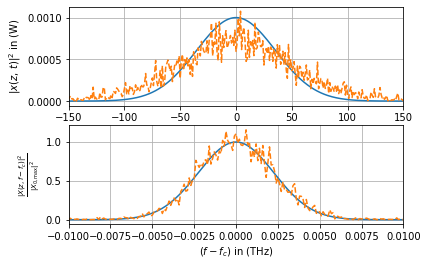

In [19]:
# Plot transmit and receive impulse
X = tf.signal.fftshift(
    tf.abs(
        tf.cast(dt, dtype) *
        tf.signal.fft(x) /
        tf.cast(tf.math.sqrt(2 * np.pi), dtype)
    ) ** 2)

fig, (ax1, ax2) = plt.subplots(2, 1)

ax1.plot(t.numpy().flatten(), np.abs(x_0.numpy().flatten())**2, '-')
ax1.plot(t.numpy().flatten(), np.abs(x.numpy().flatten())**2, '--')
ax1.set_xlim(-150, 150)
ax1.set_xlabel(r"$(t-\beta_1 z)$ in (ps)")
ax1.set_ylabel(r"$|x(z,\,t)|^2$ in (W)")
ax1.grid()

ax2.plot(
    f.numpy().flatten(),
    (X_0.numpy().flatten())/np.max(X_0.numpy().flatten()),
    '-')
ax2.plot(
    f.numpy().flatten(),
    (X.numpy().flatten())/np.max(X_0.numpy().flatten()),
    '--')
ax2.set_xlim(-0.01, 0.01)
ax2.set_xlabel(r"$(f-f_c)$ in (THz)")
ax2.set_ylabel(r"$\frac{|X(z,f-f_c)|^2}{|X_\mathrm{0,max}|^2}$")
ax2.grid()

plt.show()